# Smoothgrad (Adding noise to remove noise)
The purpose of this notebook is simply to get acquainted with smoothgrad and saliency maps in general.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
def setup_mpl():
    mpl.rcParams['font.family'] = 'Times New Roman'
    mpl.rcParams['lines.linewidth'] = 1
    return None
setup_mpl()

## Dummy CNN
Initially, we will quickly just build a CNN on MNIST to get it working

### Simple CNN

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(12544, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = torch.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = torch.log_softmax(x, dim=1)
        return output

In [5]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Subset of MNIST

In [6]:
# Load the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

# Get subset of the data
num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(0.2 * num_train))

In [7]:
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)

train_loader = DataLoader(train_dataset, batch_size=64, sampler=train_sampler)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

### Model training

In [8]:
# Instantiate the model
model = CNN().to(device)

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# For storing losses and accuracies
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Train the model
for epoch in range(1):  # Run for 10 epochs
    model.train()  # Switch to train mode
    train_loss = 0
    correct_train = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # Count number of correct predictions
        _, predicted = torch.max(output.data, 1)
        correct_train += (predicted == target).sum().item()
    
    # Compute average training loss and accuracy
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100. * correct_train / len(train_loader.dataset)
    train_accuracies.append(train_accuracy)
    
    # Compute test loss and accuracy
    model.eval()  # Switch to eval mode
    test_loss = 0
    correct_test = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()

            # Count number of correct predictions
            _, predicted = torch.max(output.data, 1)
            correct_test += (predicted == target).sum().item()
    
    # Compute average test loss and accuracy
    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    test_accuracy = 100. * correct_test / len(test_loader.dataset)
    test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss}, Test Loss: {avg_test_loss}, Training Accuracy: {train_accuracy}%, Test Accuracy: {test_accuracy}%')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1, Training Loss: 0.2386854444593191, Test Loss: 0.053241119161248206, Training Accuracy: 74.205%, Test Accuracy: 98.35%


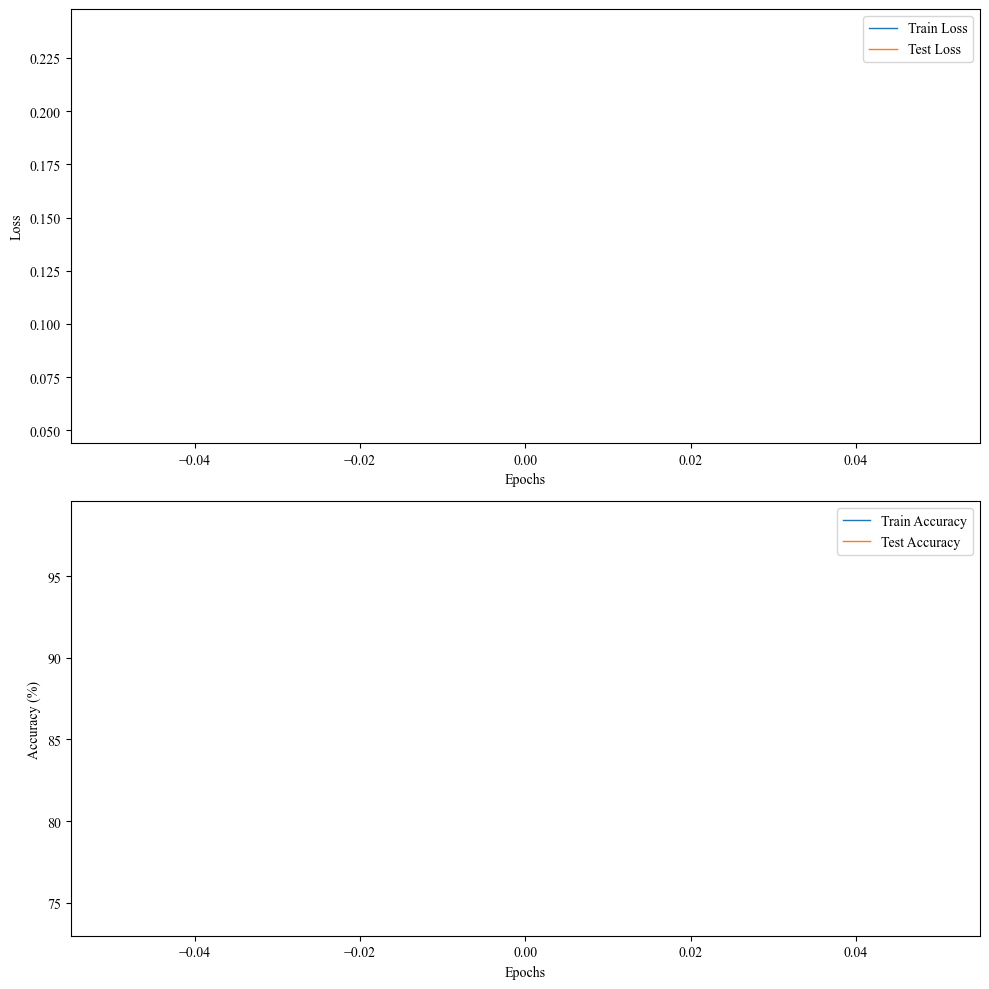

In [9]:
# Plot the learning curves
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,10), dpi=100)
ax1.plot(train_losses, label='Train Loss')
ax1.plot(test_losses, label='Test Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(train_accuracies, label='Train Accuracy')
ax2.plot(test_accuracies, label='Test Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()

plt.tight_layout()
plt.show()

## Saliency map
We are going to consider three different types of saliency maps; Vanilla, SmoothGrad, and gradCAM.

In [10]:
from saliency import visualize_saliency_map

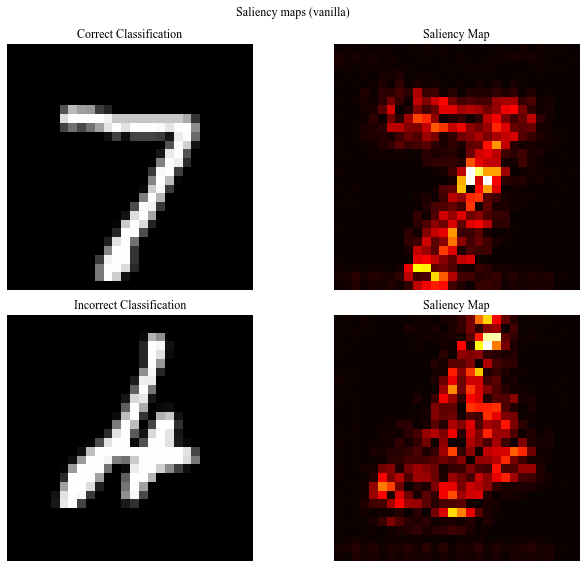

In [11]:
visualize_saliency_map(model, test_loader, method='vanilla')

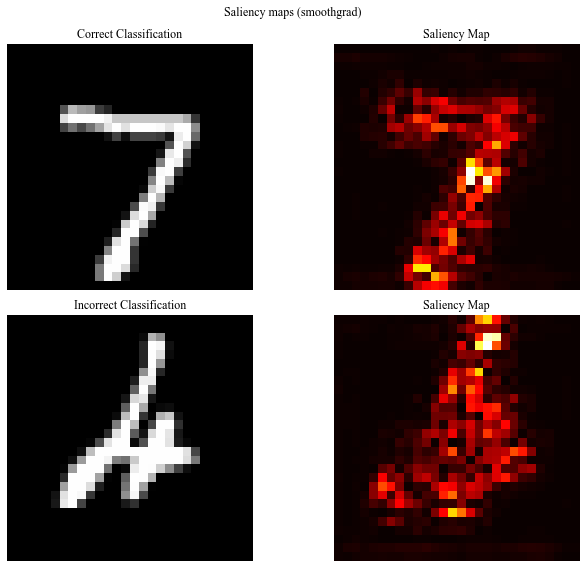

In [12]:
visualize_saliency_map(model, test_loader, method='smoothgrad', noise_level=0.1)

### Increasing noise level